In [1]:
### This software is a computer program whose for investigating
### synchrony in a fast and exhaustive way. 
### 
### This software is governed by the CeCILL-B license under French law
### and abiding by the rules of distribution of free software.  You
### can use, modify and/ or redistribute the software under the terms
### of the CeCILL-B license as circulated by CEA, CNRS and INRIA at the
### following URL "http://www.cecill.info".

### As a counterpart to the access to the source code and rights to
### copy, modify and redistribute granted by the license, users are
### provided only with a limited warranty and the software's author,
### the holder of the economic rights, and the successive licensors
### have only limited liability.
### 
### In this respect, the user's attention is drawn to the risks
### associated with loading, using, modifying and/or developing or
### reproducing the software by the user in light of its specific
### status of free software, that may mean that it is complicated to
### manipulate, and that also therefore means that it is reserved for
### developers and experienced professionals having in-depth computer
### knowledge. Users are therefore encouraged to load and test the
### software's suitability as regards their requirements in conditions
### enabling the security of their systems and/or data to be ensured
### and, more generally, to use and operate it in the same conditions
### as regards security.
### 
### The fact that you are presently reading this means that you have
### had knowledge of the CeCILL-B license and that you accept its terms.

In [2]:
import pandas as pd
import numpy as np
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, CSVLogger
import time
from keras.layers import Dense, Flatten, Dropout,Activation  
from keras.layers.recurrent import LSTM
from keras.models import Sequential, load_model
from keras.optimizers import *
from keras.layers.wrappers import TimeDistributed
from keras.layers.convolutional import (Conv2D, MaxPooling3D, Conv3D,
    MaxPooling2D)
from collections import deque
import sys
from keras import initializers
import os    
import keras
from keras.wrappers.scikit_learn import KerasRegressor 
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from hyperopt import fmin, tpe, hp, Trials

Using TensorFlow backend.


## Plot the reccurence matrix

In [3]:
def plot_result(interpol='nearest'):
        """
        This method is not fully functional. it is used for test purposes only
        """
        x=[]
        y=[]
        plt.rcParams.update(plt.rcParamsDefault)

        for index, v in np.ndenumerate(self.res[0]):
            if v==1:
                x.append(index[0])
                y.append(index[1])
        
        H, xedges, yedges = np.histogram2d(x, y, normed=True)
        extent = [yedges[0], yedges[-1], xedges[-1], xedges[0]]
        plt.imshow(H, extent=extent, interpolation=interpol)
        plt.gca().invert_yaxis()
        plt.show()
        
        
def plot_result2(Dij,threshold=0.01,w=200):   
        min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
        DijS = min_max_scaler.fit_transform(Dij)
        RijS= np.where(DijS - threshold < 0, 1, 0) 
        for i in range(RijS.shape[0]):
            for j in range(RijS.shape[1]):
                if not(j>=i-w and j<=i+w):
                    RijS[i][j] =0
        fig=plt.figure()             
        plt.imshow(RijS,cmap='Reds',  interpolation='nearest')
        plt.gca().invert_yaxis()
        plt.xlabel('frames')
        plt.ylabel('frames')
        plt.show()
     

## Pre-processing data (CNN-features)

In [4]:

def applypca(data):
    pca = PCA(n_components=2048)
    X = pca.fit_transform(data)
    expvar=pca.explained_variance_ratio_*100
    for i in range(len(expvar)+1):
            if sum(expvar[:i]) > 99:
                var= sum(expvar[:i])
                ncomponent=i
                break
        
    print("######## Done applying PCA###############")
    print("Number of pc is:  "+str(ncomponent))
    return X,ncomponent


def _load_data(data, n_prev = 12):  
    docX, docY = [],[]
    for i in range(len(data)-n_prev):
        docX.append(data.iloc[i:i+n_prev].as_matrix())
        docY.append(data.iloc[i+n_prev].as_matrix())
    alsX = np.array(docX)
    alsY = np.array(docY)

    return alsX, alsY

def train_test_split(df, test_size=0.1):  
     ntrn = round(len(df) * (1 - test_size))
     X_train, y_train = _load_data(df.iloc[0:ntrn])
     X_test, y_test = _load_data(df.iloc[ntrn:])

     return (X_train, y_train), (X_test, y_test)

def scaleDataframe(df):
        dataset = preprocessing.scale(df)
        pcaData,ncomponenet=applypca(dataset)
        df=pd.DataFrame(pcaData)
        return df,ncomponenet

def filters(pred):
        predS=(np.square(pred))
        S=np.sum(predS,axis=1)
     
        return S

## Loading Data (CNN-features)

In [5]:
 def loadingData(augment=3):
        dfE=pd.read_csv('data\\cnn-features\\Wail.txt',header=None, sep=r"\s+")
        dfS=pd.read_csv('data\\cnn-features\\Jean.txt',header=None, sep=r"\s+")
            
        dfPcaE,nc1=scaleDataframe(dfE)
        dfPcaS,nc2=scaleDataframe(dfS)
        nc=max(nc1,nc2)
        dfe=dfPcaE.iloc[:,0:nc]
        dfs=dfPcaS.iloc[:,0:nc]
        for i in range(augment):
            dfe=dfe.append(dfe)
            dfs=dfs.append(dfs)
 
        (XE_train, yE_train), (XE_test, yE_test) = train_test_split(dfe)  # retrieve data
        (XS_train, yS_train), (XS_test, yS_test) = train_test_split(dfs)  # retrieve data
             
        return (XE_train, yE_train), (XE_test, yE_test),(XE_train, yE_train), (XE_test, yE_test)

In [6]:
(XE_train, yE_train), (XE_test, yE_test),(XS_train, yS_train), (XS_test, yS_test)=loadingData(augment=1)


######## Done applying PCA###############
Number of pc is:  404
######## Done applying PCA###############
Number of pc is:  418


In [7]:
print('##### Wail training data #####')
print(XE_train.shape,yE_train.shape)
print('##### Jean training data #####')
print(XS_train.shape,yS_train.shape)

##### Wail training data #####
(1966, 12, 418) (1966, 418)
##### Jean training data #####
(1966, 12, 418) (1966, 418)


## Model training

### Keras model 

In [8]:
def modelLSTM(name,Xtrain,Ytrain,hyeropt=False,learning_rate=0.0007, hidden_neurons=10,epoch=100,batch_size=400,validation_split=0.30
                 ,in_out_neurons=418
                ,dropout_rate=0.2,Shuffle=False,min_delta=0.01, patience=5):
       #optimizer used
        optimizer = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
        callback=[]
    
       #define the model
        model = Sequential()
        model.add(LSTM(hidden_neurons, return_sequences=False,
               input_shape=(None, in_out_neurons), kernel_initializer='glorot_normal',dropout=dropout_rate))
        model.add(Dropout(dropout_rate))
        model.add(Dense(in_out_neurons, input_dim=hidden_neurons))  
        model.add(Activation("linear")) 
       
       #load model best weight warm start
        if  os.path.exists('modelCheckoint\\modelCheckpoint\\'+name+'.weights.best.hdf5') > 0 and not(hyeropt):
            print('--------Loading weights----------')
            model.load_weights('modelCheckoint\\modelCheckpoint\\'+name+'.weights.best.hdf5')
           
      
        model.compile(loss="mean_squared_error", optimizer=optimizer)
        #early stopping
        earlystopping=keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=min_delta, patience=patience, verbose=1, mode='auto')
        callback.append(earlystopping)
        if not(hyeropt):
           #model checkpoint
           filepath='C:\\Users\isir\\Desktop\\Imitation-LSTM\\modelCheckoint\\'+name+'.weights.best.hdf5'
           ModelCheckpoint=keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True, mode='auto', period=1)
#           tensorboard
#           logdr='C:\\Users\\isir\\Desktop\\Imitation-LSTM\\logs\\log'+name
#           tensorboard=keras.callbacks.TensorBoard(log_dir=logdr, histogram_freq=0, write_graph=True, write_images=False, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None)
#           callback.append(tensorboard)
#           callback.append(ModelCheckpoint)
           
         
        hist=model.fit(Xtrain, Ytrain, epochs=epoch, batch_size=batch_size, verbose=2,validation_split=0.30,shuffle=Shuffle, callbacks=callback)
                        
        return model ,hist

### Hyperparameter optimization using 'hyperopt' 

In [9]:
    #batchsize and hidden neurons search space 
    minBH=int(XE_train.shape[0]/4)-50
    maxBH=int(XE_train.shape[0]/4)+50
    # search space for learning rate
    spr={'x': hp.uniform('x', 1e-06, 1e-02)}
    # search space for hidden neurons and batchsize
    sphb={'x': hp.uniform('x', minBH-50,maxBH+50),'y': hp.uniform('y', minBH,maxBH)}

In [10]:
def modelRE(args):
       x = args['x']
       print(x)
       model,hist=modelLSTM('E',XE_train,yE_train,hyeropt=True,hidden_neurons=10,
                            learning_rate=float(x),epoch=100,batch_size=400,validation_split=0.30,min_delta=0.01, patience=4)
       a=float(hist.history['val_loss'][-1])
       return a
   
    
def modelHBE(args):
       x = args['x']
       y = args['y']
       print(x)
       model,hist=modelLSTM('E',XE_train,yE_train,hyeropt=True,hidden_neurons=int(x),learning_rate= 0.00397005172386008,epoch=1000,batch_size=int(y))
       a=float(hist.history['val_loss'][-1])
       return a
   
def modelRS(args):
       x = args['x']
       print(x)
       model,hist=modelLSTM('S',XS_train,yS_train,hyeropt=True,hidden_neurons=10,
                            learning_rate=float(x),epoch=100,batch_size=400,validation_split=0.30,min_delta=0.01, patience=4)
       a=float(hist.history['val_loss'][-1])
       return a
   
    
def modelHBS(args):
       x = args['x']
       y = args['y']
       print(x)
       model,hist=modelLSTM('S',XS_train,yS_train,hyeropt=True,hidden_neurons=int(x),learning_rate= 0.00397005172386008,epoch=1000,batch_size=int(y))
       a=float(hist.history['val_loss'][-1])
       return a

In [12]:
def optimize(objectiveFunction,sp):
        trials_to_keep = Trials()
        space=sp
        best = fmin(objectiveFunction,
            space=space,
            algo=tpe.suggest,
            max_evals=10, 
            trials = trials_to_keep)
        return best

In [13]:
    # finding best hyperparams for E Wail
    bestlearningRateE=optimize(modelRE,spr)
    bestBatchHiddenNeuronsE=optimize(modelHBE,sphb)
    
    #finding best hyperparams for S  Jean
    bestlearningRateS=optimize(modelRS,spr)
    bestBatchHiddenNeuronsS=optimize(modelHBS,sphb)
    
    
    print("hyperparams optimization take too long ")
    

0.00941433860793902
Train on 1376 samples, validate on 590 samples
Epoch 1/100
2s - loss: 4.7681 - val_loss: 4.5333
Epoch 2/100
0s - loss: 4.7370 - val_loss: 4.5157
Epoch 3/100
0s - loss: 4.7096 - val_loss: 4.4987
Epoch 4/100
0s - loss: 4.6829 - val_loss: 4.4823
Epoch 5/100
0s - loss: 4.6572 - val_loss: 4.4647
Epoch 6/100
0s - loss: 4.6301 - val_loss: 4.4464
Epoch 7/100
0s - loss: 4.6065 - val_loss: 4.4265
Epoch 8/100
0s - loss: 4.5820 - val_loss: 4.4051
Epoch 9/100
0s - loss: 4.5525 - val_loss: 4.3837
Epoch 10/100
0s - loss: 4.5234 - val_loss: 4.3618
Epoch 11/100
0s - loss: 4.5005 - val_loss: 4.3401
Epoch 12/100
0s - loss: 4.4691 - val_loss: 4.3183
Epoch 13/100
0s - loss: 4.4507 - val_loss: 4.2968
Epoch 14/100
0s - loss: 4.4259 - val_loss: 4.2755
Epoch 15/100
0s - loss: 4.3961 - val_loss: 4.2549
Epoch 16/100
0s - loss: 4.3682 - val_loss: 4.2332
Epoch 17/100
0s - loss: 4.3457 - val_loss: 4.2115
Epoch 18/100
0s - loss: 4.3242 - val_loss: 4.1900
Epoch 19/100
0s - loss: 4.2999 - val_loss:

KeyboardInterrupt: 

In [11]:
print("This time i will provide the best hyperparams ! ")
print("best learning rate",0.0098)
print('best hidden neurons',464)
print('best batch size',300)
print('keep in mind that this is just an approximation to save time, please execute the code above to ensure good quality hyperparams  ')


This time i will provide the best hyperparams ! 
best learning rate 0.0098
best hidden neurons 464
best batch size 300
keep in mind that this is just an approximation to save time, please execute the code above to ensure good quality hyperparams  


### Training LSTM for 'Wail'

In [12]:
modelE=modelLSTM('E',XE_train,yE_train,learning_rate=0.0098, hidden_neurons=464,epoch=1000,batch_size=300,validation_split=0.30,hyeropt=False
                 ,in_out_neurons=418)
modelE[0].evaluate(XE_test,yE_test)
    
   

Train on 1376 samples, validate on 590 samples
Epoch 1/1000
7s - loss: 4.5885 - val_loss: 3.4228
Epoch 2/1000
6s - loss: 3.5372 - val_loss: 2.8462
Epoch 3/1000
6s - loss: 3.0012 - val_loss: 2.4020
Epoch 4/1000
7s - loss: 2.5873 - val_loss: 2.0876
Epoch 5/1000
7s - loss: 2.2165 - val_loss: 1.8595
Epoch 6/1000
7s - loss: 1.9491 - val_loss: 1.6713
Epoch 7/1000
8s - loss: 1.7754 - val_loss: 1.5379
Epoch 8/1000
7s - loss: 1.6354 - val_loss: 1.4276
Epoch 9/1000
7s - loss: 1.5178 - val_loss: 1.3370
Epoch 10/1000
7s - loss: 1.4262 - val_loss: 1.2660
Epoch 11/1000
7s - loss: 1.3574 - val_loss: 1.2041
Epoch 12/1000
7s - loss: 1.2976 - val_loss: 1.1459
Epoch 13/1000
7s - loss: 1.2384 - val_loss: 1.0940
Epoch 14/1000
7s - loss: 1.1936 - val_loss: 1.0472
Epoch 15/1000
7s - loss: 1.1459 - val_loss: 1.0054
Epoch 16/1000
7s - loss: 1.1109 - val_loss: 0.9650
Epoch 17/1000
7s - loss: 1.0703 - val_loss: 0.9274
Epoch 18/1000
7s - loss: 1.0406 - val_loss: 0.8973
Epoch 19/1000
7s - loss: 1.0161 - val_loss: 

0.53731955473239601

### Training LSTM for 'Jean'

In [13]:
modelS=modelLSTM('S',XS_train,yS_train,learning_rate= 0.0098, hidden_neurons=464,epoch=1000,batch_size=300,validation_split=0.30,hyeropt=False
                 ,in_out_neurons=418)
    
modelS[0].evaluate(XS_test,yS_test)

Train on 1376 samples, validate on 590 samples
Epoch 1/1000
6s - loss: 4.5862 - val_loss: 3.4666
Epoch 2/1000
4s - loss: 3.5362 - val_loss: 2.8731
Epoch 3/1000
5s - loss: 3.0039 - val_loss: 2.4077
Epoch 4/1000
5s - loss: 2.5661 - val_loss: 2.1038
Epoch 5/1000
5s - loss: 2.1971 - val_loss: 1.8520
Epoch 6/1000
6s - loss: 1.9396 - val_loss: 1.6611
Epoch 7/1000
6s - loss: 1.7591 - val_loss: 1.5293
Epoch 8/1000
6s - loss: 1.6240 - val_loss: 1.4222
Epoch 9/1000
6s - loss: 1.5165 - val_loss: 1.3321
Epoch 10/1000
6s - loss: 1.4289 - val_loss: 1.2568
Epoch 11/1000
6s - loss: 1.3597 - val_loss: 1.1883
Epoch 12/1000
6s - loss: 1.3000 - val_loss: 1.1315
Epoch 13/1000
6s - loss: 1.2404 - val_loss: 1.0803
Epoch 14/1000
6s - loss: 1.1890 - val_loss: 1.0377
Epoch 15/1000
6s - loss: 1.1482 - val_loss: 1.0082
Epoch 16/1000
7s - loss: 1.1123 - val_loss: 0.9661
Epoch 17/1000
7s - loss: 1.0748 - val_loss: 0.9279
Epoch 18/1000
7s - loss: 1.0400 - val_loss: 0.8952
Epoch 19/1000
7s - loss: 1.0088 - val_loss: 

0.5325432969973638

In [14]:
    # score for model E on S
    predES= modelE[0].predict(XS_train)
    # score for model S on E
    predSE=modelS[0].predict(XE_train)  

In [15]:
    # Apply filters  and test them 
    ES=filters(predES)
    SE=filters(predSE)   

In [16]:
print(ES)

[ 2067.04956055  2618.45166016  2092.35620117 ...,  1080.421875
   982.29412842  1070.13024902]


In [17]:
print(SE)

[ 1967.29699707  2601.80859375  2104.25537109 ...,  1083.62243652
   972.60870361  1087.31787109]


## Recurrence matrix

In [19]:
def recurrence_matrix(E, S,w=200):
         """
          Rec Matrix
         """
       
         Rij = np.zeros((E.shape[0], S.shape[0]))
         Dij = np.zeros((E.shape[0], S.shape[0]))

         for i in range(E.shape[0]):
             for j in range(S.shape[0]):
                 if j>=i-w and j<=i+w:
                     Dij[i][j] = np.square(E[j] - S[i])
               
                    

         return  Dij
    

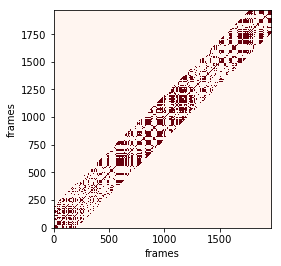

In [27]:
DijLstm=recurrence_matrix(SE, ES,w=200) 
plot_result2(DijLstm,threshold=0.01,w=200)
   
   